In [1]:
import pandas as pd
import numpy as np
import random
import math
from sklearn.metrics.pairwise import cosine_similarity
import time

from functions import train_test

In [2]:
rating_df = pd.read_csv('data/user_rating_pt.csv')
rating_df.columns = rating_df.columns.astype(int)

In [3]:
rating_treshold = 3.5

rating_df[rating_df < rating_treshold] = 0
rating_df[rating_df >= rating_treshold] = 1
rating_df.columns = range(len(rating_df.columns))

rating_df.head()

,0,1,2,3,4,5,6,7,8,9,...,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723
0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0


In [4]:
rating_df.to_csv('data/like_rating.csv', index=False)

In [5]:
pd.read_csv('data/like_rating.csv').head()

,0,1,2,3,4,5,6,7,8,9,...,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723
0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0


In [6]:
known = []
rating_matrix = rating_df.to_numpy()

for u in range(rating_df.shape[0]):
    for i in range(rating_df.shape[1]):
        if rating_df.loc[u,i] > 0:
            known.append((u, i))

training, testing = train_test(known, test_size=0.3)

In [7]:
train_matrix = np.zeros((rating_matrix.shape[0], rating_matrix.shape[1]))
test_matrix = np.zeros((rating_matrix.shape[0], rating_matrix.shape[1]))

for u, i in training:
    train_matrix[u][i] = 1

## TF-IDF Implementation

In [8]:
movie_df = pd.read_csv('ml-latest-small/movies.csv')
genre_list = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary',
              'Drama' ,'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 
              'Sci-Fi', 'Thriller', 'War', 'Western']

movies_rated = pd.read_csv('ml-latest-small/ratings.csv')['movieId'].unique()
movie_df = movie_df[movie_df['movieId'].isin(movies_rated)].reset_index(drop=True)

In [9]:
movie_genres = []
total_genres = []

for index, row in movie_df.iterrows():
    row_genre = row['genres'].split('|')
    movie_genres.append(row_genre)
    
    total_genres.append(len(row_genre))

In [10]:
tf = pd.DataFrame([])

for genre in genre_list:
    tf_genre = []
    
    for movie in movie_genres:
        if genre in movie:
            tf_genre.append(1/len(movie))
        else:
            tf_genre.append(0)
    
    tf[genre] = tf_genre

In [11]:
total_documents = len(movie_df)
idf = []

for genre in genre_list:
    genre_count = 0
    
    for movie in movie_genres:
        if genre in movie:
            genre_count += 1
    
    idf.append(math.log(total_documents/genre_count, 10))

idf = pd.Series(idf, index=genre_list)

In [12]:
tf_idf = tf*idf

In [13]:
tf_idf.shape

(9724, 18)

In [14]:
tf_idf.to_csv('data/tf_idf_genre.csv', index=False)

In [14]:
sim_matrix = cosine_similarity(tf_idf)
np.fill_diagonal(sim_matrix, 0)

sim_matrix.shape

(9724, 9724)

In [15]:
avg_sim_matrix = []

for user in train_matrix:
    liked_index = np.where(user==1)
    
    if len(liked_index[0]) != 0:
        avg_sim = sim_matrix[liked_index].mean(axis=0)
        avg_sim[liked_index] = 0
    else:
        avg_sim = [0]*train_matrix.shape[1]
    
    avg_sim_matrix.append(avg_sim)
    
avg_sim_matrix = np.array(avg_sim_matrix)

In [16]:
avg_sim_matrix.shape

(610, 9724)

## Hybrid Implementation TSUISIMCF + TFIDF

In [17]:
def get_metrics(test_set, recommend_list):
    true_positive = 0
    false_positive = 0
    false_negative = 0

    for item in recommend_list:
        if item in test_set:
            true_positive += 1
        else:
            false_positive += 1

    for item in test_set:
        if item not in recommend_list:
            false_negative+=1

    precision = true_positive/(true_positive + false_positive)
    recall = true_positive/(true_positive + false_negative)
    F1_score = 2*(precision*recall)/(precision + recall)

    print("Precision :", precision)
    print("Recall :", recall)
    print("F1 Score :", F1_score)
    
    return precision, recall, F1_score


In [18]:
def common_neighbors(dataset, by='user'):
    #since values are either 1 or 0, the dot product of two users/movies 
    #is used to find the number of common neighbors 
    if by == 'user':
        common_matrix = np.dot(dataset, dataset.T)
    elif by == 'movie':
        common_matrix = np.dot(dataset.T, dataset)
    
    return pd.DataFrame(common_matrix)

In [19]:
def jacard_coefﬁcient(dataset, by='user'):
    if by == 'user':
        jc = common_neighbors(dataset, by='user')
        sum_matrix = dataset.T.sum()      
        
    elif by == 'movie':
        jc = common_neighbors(dataset, by='movie') 
        sum_matrix = dataset.sum()
        sum_matrix.index = range(len(sum_matrix))
        
    size = len(jc)
    ones_matrix = pd.DataFrame(np.ones((size,size)))
    
    #get size of the union of two users or movies
    union_count = (sum_matrix * ones_matrix).T + (sum_matrix * ones_matrix) - jc
    
    jc = jc/union_count
    
    jc = jc.fillna(0)
    
    return jc

In [20]:
def get_recommendations(train_data, user_sim, movie_sim, k_user, n_movie, users_evaluated, cf_weight=.5):
    #list of recommeded movies to users
    recommeded_movies = []
    
    for user in users_evaluated:
        #get movies user liked
        movies = train_data.loc[user]
        liked_movies = list(movies[movies == 1].index)
       
        #get top k most similar users
        top_k = list(user_sim.loc[user].sort_values(ascending=False)[:k_user+1].index)
     
        if user in top_k:
            top_k.remove(user)
        else:
            top_k = top_k[:k_user]
        
        #get possible movie recommendations
        possible_rec = []
        
        for top_user in top_k:
         
            movies = train_data.loc[top_user]
            user_likes = list(movies[movies == 1].index)
                                
            for movie in user_likes:
                if (movie not in liked_movies) and (movie not in possible_rec):
                    possible_rec.append(movie)
        
        #get score of possible recommendations
        rec_scores = []
        
        for movie in possible_rec:
            score = cf_weight*movie_sim.loc[movie, liked_movies].max() + avg_sim_matrix[user][movie]
            rec_scores.append(score)
        
        #get top n score index
        top_index = np.argpartition(rec_scores,-n_movie)[-n_movie:]
        
        #get top movie recommendations
        for index in top_index:
            recommeded_movies.append((user, possible_rec[index]))
            
    return recommeded_movies

In [21]:
train_df = pd.DataFrame(train_matrix)

cn_movie = common_neighbors(train_df, by='movie')
jc_user = jacard_coefﬁcient(train_df, by='user')

In [26]:
recommend_list = get_recommendations(train_df, jc_user, cn_movie, 10, 5, range(train_matrix.shape[0]), cf_weight=1)
get_metrics(testing, recommend_list)

Precision : 0.24950819672131147
Recall : 0.04110180934377532
F1 Score : 0.0705773243681892


(0.24950819672131147, 0.04110180934377532, 0.0705773243681892)

In [39]:
recommend_list = get_recommendations(train_df, jc_user, cn_movie, 10, 5, range(train_matrix.shape[0]), cf_weight=.0025)
get_metrics(testing, recommend_list)

Precision : 0.2239344262295082
Recall : 0.03688900891169322
F1 Score : 0.06334338047762578


(0.2239344262295082, 0.03688900891169322, 0.06334338047762578)

In [42]:
recommend_list = get_recommendations(train_df, jc_user, cn_movie, 10, 5, range(train_matrix.shape[0]), cf_weight=.005)
get_metrics(testing, recommend_list)

Precision : 0.26295081967213113
Recall : 0.043316230083715906
F1 Score : 0.07437978205425456


(0.26295081967213113, 0.043316230083715906, 0.07437978205425456)

In [43]:
weights = [0.1, 0.075, 0.05, 0.025, 0.01, 0.0075,0.005, 0.0025]
scores = []

for w in weights:
    recommend_list = get_recommendations(train_df, jc_user, cn_movie, 10, 5, range(train_matrix.shape[0]), cf_weight=w)
    
    print("weight =", w)
    scores.append(get_metrics(testing, recommend_list))

weight = 0.1
Precision : 0.25081967213114753
Recall : 0.0413178503915744
F1 Score : 0.07094829584975655
weight = 0.075
Precision : 0.2518032786885246
Recall : 0.04147988117742371
F1 Score : 0.07122652446093206
weight = 0.05
Precision : 0.25606557377049183
Recall : 0.042182014582770724
F1 Score : 0.07243218177602596
weight = 0.025
Precision : 0.26262295081967213
Recall : 0.04326221982176614
F1 Score : 0.07428703918386274
weight = 0.01
Precision : 0.2695081967213115
Recall : 0.044396435322711314
F1 Score : 0.07623463946209134
weight = 0.0075
Precision : 0.26688524590163937
Recall : 0.04396435322711315
F1 Score : 0.07549269649895664
weight = 0.005
Precision : 0.26295081967213113
Recall : 0.043316230083715906
F1 Score : 0.07437978205425456
weight = 0.0025
Precision : 0.2239344262295082
Recall : 0.03688900891169322
F1 Score : 0.06334338047762578


## Graph

In [44]:
precision_list = []
recall_list = []
F1_list = []

for s in scores:
    precision_list.append(s[0])
    recall_list.append(s[1])
    F1_list.append(s[2])

In [46]:
import matplotlib.pyplot as plt

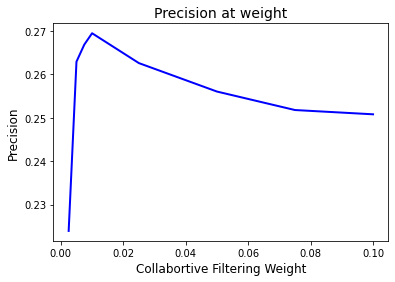

In [50]:
plt.plot(weights, precision_list, color='blue', linewidth=2)

plt.title('Precision at Weight', size=14)
plt.xlabel('Collabortive Filtering Weight', size=12)
plt.ylabel('Precision', size=12)


plt.show()

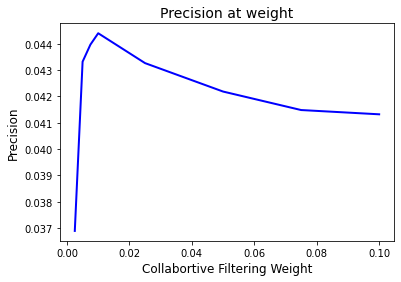

In [48]:
plt.plot(weights, recall_list, color='blue', linewidth=2)

plt.title('Precision at weight', size=14)
plt.xlabel('Collabortive Filtering Weight', size=12)
plt.ylabel('Precision', size=12)


plt.show()